# DS15 Lecture Topic Modeling
## IMBD Movie Reviews

Author: DS15 :D 

## Guiding Question
What are common themes in movies that people liked?

## Approach
* Apply NLP to movie reviews
* Estimate a topic model on the movie reviews
* Create visualizations relating the topics to the review scoes

In [1]:
import pandas as pd

df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.shape

(40436, 2)

In [5]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [8]:
# Remove html tags
df['review'] = df['review'].apply(lambda x: x.replace('<br />', ''))

In [9]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Applying NLP
* We need to tokenize the text
* How should we do it?
- Use Spacy
- figure out what our unit our unit of analysis (lemmas, adjs, keywords, nouns, spacy tokens, etc.)

In [10]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [12]:
# Try Lemmatization as our first Experiment
# Future Extend Stop to include "film & movie"

stop_words = nlp.Defaults.stop_words.union(['film', 'movie', 'actor'])

def get_lemmas(text):
    
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc:
        conditions = (token.is_stop == False) and (token.is_punct == False) and (token.pos_ != 'PRON') and (token is not stop_words)
        if conditions:
            lemmas.append(token.lemma_)
    
    return lemmas

In [14]:
df['lemmas'] = df['review'].apply(get_lemmas)

In [ ]:
def get_lemmas(texts):
    
    ln = len(texts)
    all_lemmas = []
    
    for i, text in enumerate(texts):
    
        lemmas = []

        doc = nlp(text)

        for token in doc:
            conditions = (token.is_stop == False) and (token.is_punct == False) and (token.pos_ != 'PRON')
            if conditions:
                lemmas.append(token.lemma_)
        
        all_lemmas.append(lemmas)
        print(f"{((i/ln)*100:.2f}%")
    
    return lemmas

In [30]:
df['lemmas'] = df['lemmas'].apply(lambda x: [l for l in x if l not in ['movie', 'film', 'character', 'actor']])

## Topic Modeling w/ Gensim
* Learn a Vocabulary
* Create a Bag of Words (BoW) representation of each document
* Estimate our LDA model
* Clean up the results
* Add topic information back to dataframe

In [15]:
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [33]:
id2word = corpora.Dictionary(df['lemmas'])

In [40]:
id2word.filter_extremes(no_below=50, no_above=.90)

In [42]:
len(id2word.keys())

7326

In [41]:
corpus = [id2word.doc2bow(doc) for doc in df['lemmas']]

In [43]:
lda = LdaMulticore(corpus=corpus, 
                   id2word=id2word,
                   num_topics = 5, 
                   passes=100,
                   workers=12, 
                   random_state=812
                  )

In [46]:
lda.print_topics()

[(0,
  '0.013*"good" + 0.013*"play" + 0.009*"role" + 0.009*"great" + 0.007*"performance" + 0.006*"cast" + 0.006*"star" + 0.006*"comedy" + 0.005*"time" + 0.005*"like"'),
 (1,
  '0.020*"bad" + 0.020*"like" + 0.015*"good" + 0.013*"watch" + 0.010*"think" + 0.009*"see" + 0.009*"time" + 0.009*"look" + 0.007*"thing" + 0.007*"get"'),
 (2,
  '0.007*"man" + 0.006*"kill" + 0.005*"series" + 0.004*"time" + 0.004*"war" + 0.004*"episode" + 0.004*"get" + 0.004*"take" + 0.004*"find" + 0.004*"come"'),
 (3,
  '0.013*"love" + 0.012*"like" + 0.011*"watch" + 0.011*"life" + 0.011*"see" + 0.011*"story" + 0.010*"time" + 0.010*"good" + 0.010*"think" + 0.009*"people"'),
 (4,
  '0.010*"story" + 0.008*"scene" + 0.006*"work" + 0.006*"director" + 0.005*"plot" + 0.005*"time" + 0.005*"like" + 0.004*"good" + 0.004*"way" + 0.004*"make"')]

In [57]:
import re

words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [58]:
topics = [' '.join(t[0:5]) for t in words]

In [59]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
good play role great performance

------ Topic 1 ------
bad like good watch think

------ Topic 2 ------
man kill series time war

------ Topic 3 ------
love like watch life see

------ Topic 4 ------
story scene work director plot



## Analyzing the Results of LDA
- How go are the topics themselves?
    * Using intertopic distance visualization
    * Looking at some of the token distributions
- Using the LDA topics for analysis:
    *  Score each review with a top topic
    *  Summary visualization of topic topic versus sentiment

In [44]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [45]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.125986  0.004202       1        1  28.135002
4      0.022210  0.022885       2        1  20.554760
3      0.058246 -0.031072       3        1  19.555672
0     -0.107677 -0.130821       4        1  16.309864
2     -0.098766  0.134806       5        1  15.444700, topic_info=       Term          Freq         Total Category  logprob  loglift
380     bad  21064.000000  21064.000000  Default  30.0000  30.0000
97    watch  22229.000000  22229.000000  Default  29.0000  29.0000
178    love  13418.000000  13418.000000  Default  28.0000  28.0000
130    play  13628.000000  13628.000000  Default  27.0000  27.0000
328    role   6670.000000   6670.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
82     show   1305.662354   7261.364258   Topic5  -6.0080   0.1520
75    scene   1317.578613  17115.070312   Topic5  -5.9990  -0.6963
272  people   1291.441772  14035.087891   Topic5  -6.0190  -0.5179
247  action   1268.009888   5790.137207   Topic5  -6.0373   0.3492
125     old   1270.505127   8022.598633   Topic5  -6.0353   0.0251

[473 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5720      1  0.997683       0
2772      1  0.996768    1/10
148       1  0.793651       2
148       2  0.008789       2
148       3  0.118359       2
...     ...       ...     ...
202       5  0.138483   young
235       1  0.999599  zombie
3387      2  0.946675       
3387      4  0.004615       
3387      5  0.048718       

[1174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 3])

### Label Our Reviews with the most common topic

In [50]:
doc_topics = [lda[doc] for doc in corpus]

In [51]:
doc_topics[0]

[(1, 0.03728466), (2, 0.353632), (3, 0.22769623), (4, 0.37967926)]

In [60]:
def update(doc):
        d_dist = {k:0 for k in range(0,5)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in doc_topics]

In [61]:
dft = pd.DataFrame.from_records(new_distro)
dft.columns = topics

In [62]:
dft.head()

,good play role great performance,bad like good watch think,man kill series time war,love like watch life see,story scene work director plot
0,0.000000,0.037285,0.353632,0.227696,0.379679
1,0.203046,0.000000,0.000000,0.038818,0.751822
2,0.414650,0.178973,0.052645,0.226549,0.127183
3,0.000000,0.421858,0.113991,0.389089,0.071180
4,0.281229,0.000000,0.000000,0.447080,0.267135


In [66]:
df['primary_topic'] = dft.idxmax(axis=1)

In [67]:
df.head()

,review,sentiment,lemmas,primary_topic
0,One of the other reviewers has mentioned that ...,positive,"[reviewer, mention, watch, 1, Oz, episode, hoo...",story scene work director plot
1,A wonderful little production. The filming tec...,positive,"[wonderful, little, production, filming, techn...",story scene work director plot
2,I thought this was a wonderful way to spend ti...,positive,"[think, wonderful, way, spend, time, hot, summ...",good play role great performance
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, Jake, think, ...",bad like good watch think
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, love, Time, money, visually, ...",love like watch life see


In [ ]:
# Scatter Plot?

In [ ]:
# Seaborn Heatmap?  

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

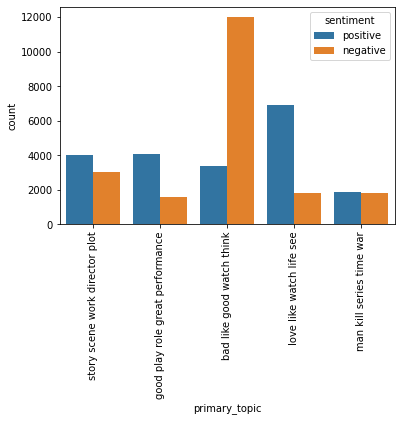

In [75]:
# Simple Bar Graph? 

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x="primary_topic", hue="sentiment", data=df)
plt.xticks(rotation=90)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values